# Assignment 3 (Part 1): Logistic Regression using PyTorch (Starter)

* Student Name: Paul Barrett
* Enrollment Status: UNDERGRADUATE STUDENT

In this assignment, you will fit logistic regression models to each of the six synthetic datasets you used for first assignment.  Your goal will be to obtained the lowest average test loss across all datasets using a single set of features and optimization parameters.

Things to include in the writeup:

* For the best model you found: 
   * The source code for your implementation of `_expand_features` in `FancyLogisticRegressionModel`.
   * The source code for the "Training parameters".
   * The visualization (image) of the final models fit by your method for each dataset.
   * The final average test loss your model obtained.
* If you did not obtain an average test loss below 0.1, then you must also include the following:
   * The code (`_expand_features`) for at least three additional features spaces you tried along with their average test losses.
   * A description of the range of "Training parameters" you tried (for example, I tried these four optimizers, this range of learning rates, and this range of epochs).

Advice on installing PyTorch:

* If you are setting this up in a virtual environment on your own machine, make sure you also install ipython and jupyter in the environment.  If you don't do this, then you may end up running the jupyter notebook from your base python installation.  This can cause problems when it tries to load the PyTorch in your virtual environment.

Advice on finding a good set of features and training parameters:

* It isn't required, but you could do a randomized parameter search to solve for the optimal model parameters.  The way that works is that you randomly pick a set of training parameters from within some range and train the model.  You do this repeatedly and keep the model that performs best your validation dataset.  The nice thing about this approach is that you can just start it running and come back in the morning to see the best model.
* Make sure your features are relatively the same magnitude.  You may need to divide by a constant.
* You may want to record and plot the loss at each iteration to help you debug.
* Get your model working well on simple datasets first.
* If increasing the number of epochs makes your model worse, then you probably should increase regularization.
* You could speed up the overall training time by adding a convergence criteria, for example, if the loss doesn't go down by a certain amount for a few updates.


# Setup Environment

This is designed to work in Google Colab.  You may need to do some of these from the command line if you are using your own installation of Jupyter/Python.

In [15]:
# !pip3 install torch didn't work for me
# this method was found on pytorch.org
!pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.1-cp36-cp36m-win_amd64.whl
!pip3 install torchvision

In [16]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Build some simple datasets

These should look familiar.

In [627]:
def gen_from_mean_and_cov(means, covs, labels, mode='train', count=100):
  
  np.random.seed(0) if mode == 'train' else np.random.seed(1)
      
  vals = np.array([]).reshape(0,len(means[0])+1)

  for i, (mean,cov,label) in enumerate(zip(means,covs,labels)):
    vals_new = np.random.multivariate_normal(mean,cov,count)/10.;
    vals_new = np.hstack([vals_new,np.ones((vals_new.shape[0],1))*label])
    vals = np.vstack([vals,vals_new])    

  df = pd.DataFrame(data=vals,columns=['x1','x2','y'])

  return df

# There are 6 different simple training datasets

datasets = {
    'train1':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[1,0]),
    'train2':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[0,1]),
    'train3':gen_from_mean_and_cov([[0,1],[0,3.5]],[[[1, .8],[.8, 1]],[[1, .8],[.8, 1]]],[1,0]),
    'train4':gen_from_mean_and_cov([[1,0],[3,1]],[[[1, .8],[.8, 1]],[[1, .9],[.9, 1]]],[1,0]),
    'train5':gen_from_mean_and_cov([[0,0],[4,0],[-4,0],[0,4],[0,-4]],[[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],[1,0,0,0,0]),
    'train6':gen_from_mean_and_cov(
    [[0,0],[4,0],[-4,0],[0,4],[0,-4],[-4,4],[4,4],[4,-4],[-4,-4]],
    [[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],
    [1,0,0,0,0,1,1,1,1]),
    'test1':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[1,0],mode='test'),
    'test2':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[0,1],mode='test'),
    'test3':gen_from_mean_and_cov([[0,1],[0,3.5]],[[[1, .8],[.8, 1]],[[1, .8],[.8, 1]]],[1,0],mode='test'),
    'test4':gen_from_mean_and_cov([[1,0],[3,1]],[[[1, .8],[.8, 1]],[[1, .9],[.9, 1]]],[1,0],mode='test'),
    'test5':gen_from_mean_and_cov([[0,0],[4,0],[-4,0],[0,4],[0,-4]],[[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],[1,0,0,0,0],mode='test'),
    'test6':gen_from_mean_and_cov(
    [[0,0],[4,0],[-4,0],[0,4],[0,-4],[-4,4],[4,4],[4,-4],[-4,-4]],
    [[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],
    [1,0,0,0,0,1,1,1,1],mode='test')
}

df = datasets['train6']

## Helpful Code

In [422]:
# visualize the classifer
def vis2d_classifier(net,data):
  
  # create the domain for the plot
  x1_min = data.x1.min()
  x1_max = data.x1.max()
  x2_min = data.x2.min()
  x2_max = data.x2.max()

  X1,X2 = np.meshgrid(
      np.linspace(x1_min, x1_max, 200),
      np.linspace(x2_min, x2_max, 200))

  # convert it into a matrix (rows are locations, columns are features)
  vis_data = np.hstack([X1.reshape(-1,1),X2.reshape(-1,1)])

  # classify each location
  vis_sco = net(torch.tensor(vis_data,dtype=torch.float32))

  # convert back into image shapes
  vis_sco = vis_sco.detach().numpy().reshape(X1.shape)
  vis_class = vis_sco > .5;
  
  #
  # Make the plots
  #

  # show the function value in the background
  cs = plt.imshow(vis_sco,
    extent=(x1_min,x1_max,x2_max,x2_min), # define limits of grid, note reversed y axis
    cmap=plt.cm.jet, vmin=0.,vmax=1.)
  plt.clim(0,1) # defines the value to assign the min/max color

  # draw the line on top
  levels = np.array([.5])
  cs_line = plt.contour(X1,X2,vis_sco,levels, colors='k')

  plt.scatter(data.x1,data.x2,c=data.y,edgecolors='w',cmap=plt.get_cmap('jet'))

  # add a color bar
  CB = plt.colorbar(cs)

  plt.show()

# Setup the model

** TASK: ** edit `_expand_features` so that this model works better.  See the last cell for a comparison to the best possible model.


In [717]:
class FancyLogisticRegressionModel(nn.Module):

    def __init__(self):

        super(FancyLogisticRegressionModel, self).__init__()

        # compute the number of input features
        self.input_dims = self._expand_features(torch.zeros(1,2)).shape[1]
        #self.input_dims = self._expand_features(torch.zeros(1,3)).shape[1]
        
        self.linear = nn.Linear(self.input_dims, 1)
        self.sig = nn.Sigmoid()
     
    #
    # perform basis expansion (change this so it work for all datasets!)
    #
    def _expand_features(self, x):
            
        # this currently constructs a 2nd-order polynomial model
        #x_expanded = torch.stack([x[:,0], x[:,1], (x[:,0]**2)/2., (x[:,1]**2)/2., (x[:,0]*x[:,1])/2.],dim=1)
        #x_expanded = torch.stack([x[:,0], x[:,1], x[:,2], (x[:,0]**3)/3., (x[:,1]**3)/3., (x[:,2]**3)/3., (x[:,0]*x[:,1])/2., (x[:,0]*x[:,2])/2., (x[:,2]*x[:,1])/2.],dim=1)
        #x_expanded = torch.stack([x[:,0], x[:,1], (x[:,0]**2)/2., (x[:,0]**3)/9., (x[:,0]**4)/32., (x[:,0]**5)/100., (x[:,0]**6)/1000., (x[:,0]**7)/10000., (x[:,1]**2)/2., (x[:,1]**3)/9., (x[:,1]**4)/32., (x[:,1]**5)/100., (x[:,1]**6)/1000., (x[:,1]**7)/10000., (x[:,0]*x[:,1])/2.],dim=1)
        #x_expanded = torch.stack([x[:,0], x[:,1], (x[:,0]**2)/2., (x[:,0]**3)/9., (x[:,0]**4)/32., (x[:,0]**5)/100., (x[:,0]**6)/1000., (x[:,0]**7)/10000., (x[:,0]**8)/100000., (x[:,1]**2)/2., (x[:,1]**3)/9., (x[:,1]**4)/32., (x[:,1]**5)/100., (x[:,1]**6)/1000., (x[:,1]**7)/10000., (x[:,1]**8)/100000., (x[:,0]**9)/500000., (x[:,1]**9)/500000., (x[:,0]*x[:,1])/2.],dim=1)
        #x_expanded = torch.stack([x[:,0], x[:,1], (x[:,0]**2)/2., (x[:,0]**3)/9., (x[:,0]**4)/32., (x[:,0]**5)/100., (x[:,0]**6)/5000., (x[:,0]**7)/10000., (x[:,0]**8)/50000., (x[:,1]**2)/2., (x[:,1]**3)/9., (x[:,1]**4)/32., (x[:,1]**5)/100., (x[:,1]**6)/1000., (x[:,1]**7)/5000., (x[:,1]**8)/10000., (x[:,0]**9)/50000., (x[:,1]**9)/50000., (x[:,0]*x[:,1])/2.],dim=1)
        
        #best model, 8th order polynomial with guessed normalization (~1.53)
        x_expanded = torch.stack([x[:,0], x[:,1], (x[:,0]**2)/2., (x[:,0]**3)/9., (x[:,1]**2)/2., (x[:,1]**3)/9., (x[:,1]**4)/16., (x[:,0]**4)/16., (x[:,1]**5)/25., (x[:,0]**5)/25., (x[:,0]*x[:,1])/2., (x[:,1]**6)/64., (x[:,0]**6)/64., (x[:,1]**7)/128., (x[:,0]**7)/128., (x[:,1]**8)/256., (x[:,0]**8)/256.],dim=1)
        
        #feature scaled (min/max normalization) 3rd-order polynomial model
        #x_expanded = torch.stack([((x[:,0] - min(x[:,0]))/(max(x[:,0])-min(x[:,0]))), ((x[:,1] - min(x[:,1]))/(max(x[:,1])-min(x[:,1]))), ((x[:,0]**2 - min(x[:,0]**2))/(max(x[:,0]**2) - min(x[:,0]**2))), ((x[:,1]**2 - min(x[:,1]**2))/(max(x[:,1]**2) - min(x[:,1]**2))), ((x[:,0]**3 - min(x[:,0]**3))/(max(x[:,0]**3) - min(x[:,0]**3))), ((x[:,1]**3 - min(x[:,1]**3))/(max(x[:,1]**3) - min(x[:,1]**3))), (((x[:,0]*x[:,1]) - min((x[:,0]*x[:,1])))/(max((x[:,0]*x[:,1]))-min((x[:,0]*x[:,1])))) ],dim=1)
        
        #feature scaled (min/max normalization) 4th-order polynomial model
        #x_expanded = torch.stack([((x[:,0] - min(x[:,0]))/(max(x[:,0])-min(x[:,0]))), ((x[:,1] - min(x[:,1]))/(max(x[:,1])-min(x[:,1]))), ((x[:,0]**2 - min(x[:,0]**2))/(max(x[:,0]**2) - min(x[:,0]**2))), ((x[:,1]**2 - min(x[:,1]**2))/(max(x[:,1]**2) - min(x[:,1]**2))), ((x[:,0]**3 - min(x[:,0]**3))/(max(x[:,0]**3) - min(x[:,0]**3))), ((x[:,1]**3 - min(x[:,1]**3))/(max(x[:,1]**3) - min(x[:,1]**3))), (((x[:,0]*x[:,1]) - min((x[:,0]*x[:,1])))/(max((x[:,0]*x[:,1]))-min((x[:,0]*x[:,1])))), ((x[:,0]**4 - min(x[:,0]**4))/(max(x[:,0]**4) - min(x[:,0]**4))), ((x[:,1]**4 - min(x[:,1]**4))/(max(x[:,1]**4) - min(x[:,1]**4))) ],dim=1)
        
        return x_expanded
    
    def forward(self, x):

      # Add basis expansion here, make sure to adjust the self.input_dims
      # accordingly in __init__.
      
      x_expanded = self._expand_features(x) # do basis expansion
      logits = self.linear(x_expanded) # predict the logits
      probs = self.sig(logits) # compute the probability for each example
      return probs

## Visualize a random classifier

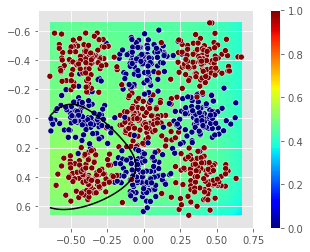

In [708]:
vis2d_classifier(FancyLogisticRegressionModel(),df)

# Optimize Networks for Each Dataset

The code below optimizes the model.

Dataset 1, Epoch [5000/5000], Train Loss: 0.0000, Test Loss: 0.0000


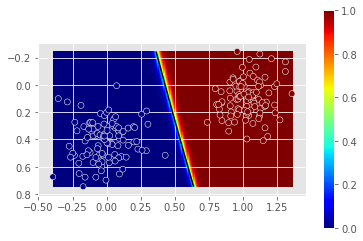

Dataset 2, Epoch [5000/5000], Train Loss: 0.0000, Test Loss: 0.0000


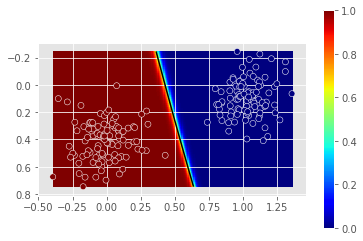

Dataset 3, Epoch [5000/5000], Train Loss: 0.0512, Test Loss: 0.0347


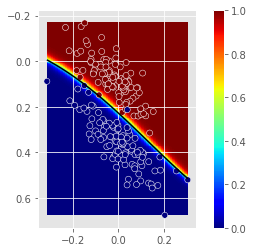

Dataset 4, Epoch [5000/5000], Train Loss: 0.1818, Test Loss: 0.1791


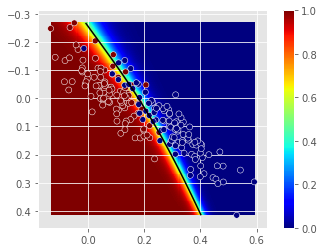

Dataset 5, Epoch [5000/5000], Train Loss: 0.1065, Test Loss: 0.0898


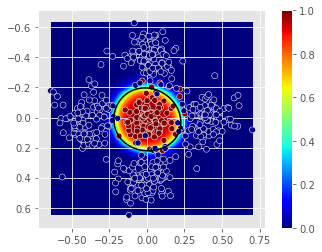

Dataset 6, Epoch [5000/5000], Train Loss: 0.5983, Test Loss: 0.6075


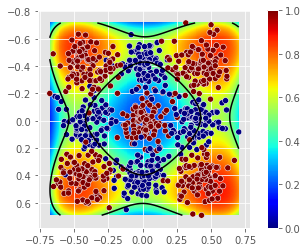

In [723]:
#
# Training parameters (INCLUDE THESE IN YOUR WRITEUP)
#

learning_rate = .075             # 0.065 < LR < 0.2
max_epochs = 5000                # >= 5000 unless on mix/max feature scaling
opt_method = torch.optim.RMSprop # RMSprop or Adam
weight_decay = 1e-10             # Does best between -8 and -20

#
# You shouldn't modify anything below here, but you should definitely read it
# to understand what is happening.
#

# Store average losses
test_losses = []

# Fit all models
for data_id in range(1,7):

  # gather the train/test datasets
  df_train = datasets['train{}'.format(data_id)]
  df_test = datasets['test{}'.format(data_id)]

  # initialize a model
  net = FancyLogisticRegressionModel()

  # define the loss
  loss_function = nn.BCELoss()

  # define an optimizer
  optimizer = opt_method(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # build the torch tensors
  feats_train = torch.tensor(df_train[['x1','x2']].values, dtype=torch.float32);
  vals_train = torch.tensor(df_train[['y']].values, dtype=torch.float32);

  feats_test = torch.tensor(df_test[['x1','x2']].values,dtype=torch.float32)
  vals_test = torch.tensor(df_test[['y']].values, dtype=torch.float32)
  
  # run gradient descent
  for epoch in range(max_epochs):
    
    optimizer.zero_grad();               # Intialize the gradient accumulators to all zeros
    outputs = net(feats_train);                # Forward pass: compute the output class given a image
    loss = loss_function(outputs, vals_train); # Compute the loss: difference between the output class and the pre-given label
    loss.backward();                     # Backward pass: compute the weight
    optimizer.step();                    # Optimizer: update the weights of hidden nodes
    
  # compute and store test loss
  test_loss = loss_function(net(feats_test), vals_test)
  test_losses.append(float(test_loss))
    
  print('Dataset %d, Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' % (data_id, epoch+1, max_epochs, float(loss), float(test_loss)))

  plt.figure()
  vis2d_classifier(net,df_test)

## Compute the Average Test Loss

In [722]:
print('The average test loss across all datasets for your model was {:2.3}.'.format(np.array(test_losses).mean()))

The average test loss across all datasets for your model was 0.153.


The best average loss I obtained was aroundd 0.084 (although this varies a bit every time due to the random initialization).  Can you do better?